# Inference notenook

Disclaimer: the authors do not own any rights for the code or data.

In [1]:
#@title Imports
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
#from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch.nn.functional as F
N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, '../gpt2_BLIP_epoch_10')


In [9]:
class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class SceneAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(SceneAttention, self).__init__()
        self.global_query = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.cross_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B = x.size(0)
        query = self.global_query.expand(B, -1, -1)
        scene_out, attn_weights = self.cross_attention(query, x, x)
        # Return both the normalized scene representation and the attention weights
        return self.norm(scene_out), attn_weights


# --- Object Attention ---
class ObjectAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(ObjectAttention, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.cross_scene_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, object_features, scene_context):
        obj_attn, self_attn_weights = self.self_attention(object_features, object_features, object_features)
        scene_attn, cross_attn_weights = self.cross_scene_attention(object_features, scene_context, scene_context)
        combined = obj_attn + scene_attn
        # Optionally, you can combine the weights or return them separately.
        attn_weights = (self_attn_weights + cross_attn_weights) / 2.0
        return self.norm(combined), attn_weights


# --- Graph Interaction ---
class GraphInteraction(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(GraphInteraction, self).__init__()
        self.edge_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, graph_mask=None):
        B, N, D = x.shape
        if graph_mask is not None:
            num_heads = self.edge_attention.num_heads
            graph_mask = graph_mask.unsqueeze(1).repeat(1, num_heads, 1, 1).reshape(B * num_heads, N, N)
            graph_mask = graph_mask.masked_fill(graph_mask == 0, float('-inf')).masked_fill(graph_mask == 1, 0.0)
        else:
            graph_mask = None

        edge_out, attn_weights = self.edge_attention(x, x, x, attn_mask=graph_mask)
        return self.norm(edge_out), attn_weights


# --- Gated Fusion ---
class GatedFusion(nn.Module):
    def __init__(self, embed_dim):
        super(GatedFusion, self).__init__()
        self.gate = nn.Linear(embed_dim * 3, 3)
        self.proj = nn.Linear(embed_dim * 3, embed_dim)

    def forward(self, scene, obj, graph):
        combined = torch.cat([scene, obj, graph], dim=-1)
        gate_weights = torch.softmax(self.gate(combined), dim=-1)
        fused = gate_weights[..., 0:1] * scene + gate_weights[..., 1:2] * obj + gate_weights[..., 2:3] * graph
        return self.proj(torch.cat([fused, obj, graph], dim=-1))

# --- Similarity Mask Generator ---
def generate_similarity_mask(object_features, threshold=0.8):
    B, N, D = object_features.size()
    normed = F.normalize(object_features, dim=-1)
    sim_matrix = torch.matmul(normed, normed.transpose(1, 2))
    attention_mask = (sim_matrix >= threshold).float()
    return attention_mask

# --- Final Model ---
class EnhancedClipCaptionModel(nn.Module):
    def __init__(self, embed_dim=512, prefix_length=10):
        super(EnhancedClipCaptionModel, self).__init__()
        self.scene_attention = SceneAttention(embed_dim)
        self.object_attention = ObjectAttention(embed_dim)
        self.graph_interaction = GraphInteraction(embed_dim)
        self.gated_fusion = GatedFusion(embed_dim)

        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.prefix_proj = nn.Linear(embed_dim, self.gpt.config.n_embd)
        self.prefix_length = prefix_length

    def forward(self, tokens, visual_prefix, mask):
        if visual_prefix.dim() == 2:
            visual_prefix = visual_prefix.unsqueeze(1)

        scene_features = self.scene_attention(visual_prefix)
        object_features = self.object_attention(visual_prefix, scene_features)
        graph_mask = generate_similarity_mask(visual_prefix)
        graph_features = self.graph_interaction(visual_prefix, graph_mask=graph_mask)

        scene_expanded = scene_features.expand(-1, object_features.size(1), -1)
        fused_features = self.gated_fusion(scene_expanded, object_features, graph_features)

        fused = fused_features.mean(dim=1)
        prefix_embeds = self.prefix_proj(fused).unsqueeze(1).repeat(1, self.prefix_length, 1)

        gpt_inputs = self.gpt.transformer.wte(tokens)
        inputs_embeds = torch.cat((prefix_embeds, gpt_inputs), dim=1)

        text_mask = mask[:, :tokens.shape[1]]
        new_mask = torch.cat(
            (torch.ones(tokens.size(0), self.prefix_length).to(tokens.device), text_mask), dim=1
        )
        assert new_mask.shape[1] == inputs_embeds.shape[1]

        labels = torch.cat((
            torch.full((tokens.size(0), self.prefix_length), -100).to(tokens.device),
            tokens
        ), dim=1)

        outputs = self.gpt(inputs_embeds=inputs_embeds, attention_mask=new_mask, labels=labels)
        return outputs


In [10]:
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=0.8, stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=100,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [11]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}  


In [12]:
#@title CLIP model + GPT2 tokenizer
from transformers import BlipProcessor, BlipModel

device = CUDA(0) if is_gpu else "cpu"
#clip_model, preprocess = clip.load("RN101", device=device, jit=False)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
BLIPmodel = BlipModel.from_pretrained("Salesforce/blip-image-captioning-large").vision_model.to(device)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-large and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_m

In [13]:
#@title Load model weights


prefix_length =10
embed_dim = 1024
model = EnhancedClipCaptionModel(embed_dim=embed_dim,prefix_length=prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


In [14]:
total_params_model = sum(p.numel() for p in model.parameters())
total_params_BLIP = sum(p.numel() for p in BLIPmodel.parameters())
print(f"Total parameters in the model: {(total_params_model+total_params_BLIP)/1e6}")

Total parameters in the model: 448.874499


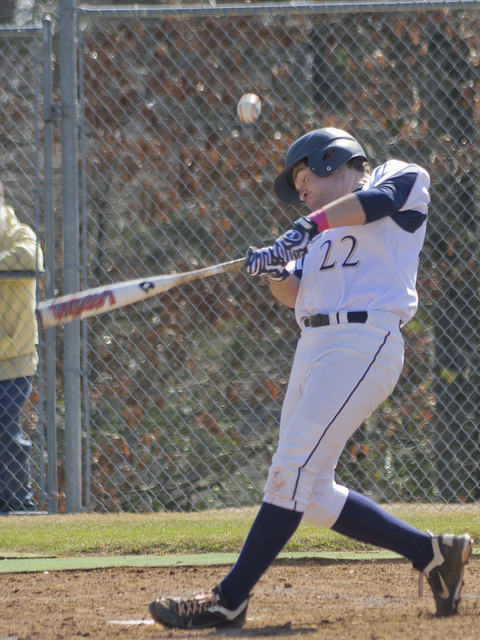

Generated Text: a baseball player swinging a bat at a ball                                                          


In [43]:
import pickle


use_beam_search = True  #@param {type:"boolean"}  

image= io.imread("/home/nasser.gawfan/Desktop/image_dataset/MSCOCO2017/test2017/000000000016.jpg")
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = processor(images=pil_image, return_tensors="pt").pixel_values.to(device)

with torch.no_grad():
    
    prefix = BLIPmodel(image).last_hidden_state[:, 0, :].to(device)

    if prefix.dim() == 2:
            prefix = prefix.unsqueeze(1)

    scene_features,_ = model.scene_attention(prefix)
    object_features, _ = model.object_attention(prefix, scene_features)
    graph_mask = generate_similarity_mask(prefix)
    graph_features,_= model.graph_interaction(prefix, graph_mask=graph_mask)

    scene_expanded = scene_features.expand(-1, object_features.size(1), -1)
    fused_features = model.gated_fusion(scene_expanded, object_features, graph_features)

    fused = fused_features.mean(dim=1)
    prefix_embeds = model.prefix_proj(fused).unsqueeze(1).repeat(1, model.prefix_length, 1)

    
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embeds)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embeds)


print("Generated Text:",generated_text_prefix)

## Generating Results

In [21]:
import os
import json
import torch
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

test_images_dir = '/home/nasser.gawfan/Desktop/image_dataset/flickr30k/Test_set'
output_json_path = '/home/nasser.gawfan/CLIP_prefix_caption/experiment_final2/filikr30k_pred.json'
use_beam_search = True

def generate_caption_for_image(image, model, tokenizer, use_beam_search, prefix_length, device):
    with torch.no_grad():
        #image_tensor = preprocess(image).unsqueeze(0).to(device)
        image_tensor = processor(images=image, return_tensors="pt").pixel_values.to(device)

        #prefix = clip_model.encode_image(image_tensor).to(device, dtype=torch.float32)
        prefix = BLIPmodel(image_tensor).last_hidden_state[:, 0, :]
        
        if prefix.dim() == 2:
            prefix = prefix.unsqueeze(1)

        scene_features = model.scene_attention(prefix)
        object_features = model.object_attention(prefix, scene_features)
        graph_mask = generate_similarity_mask(prefix)
        graph_features = model.graph_interaction(prefix, graph_mask=graph_mask)

        scene_expanded = scene_features.expand(-1, object_features.size(1), -1)
        fused_features = model.gated_fusion(scene_expanded, object_features, graph_features)

        fused = fused_features.mean(dim=1)
        prefix_embeds = model.prefix_proj(fused).unsqueeze(1).repeat(1, model.prefix_length, 1)
    
        

        if use_beam_search:
            generated_text = generate_beam(model, tokenizer, embed=prefix_embeds)[0]
        else:
            generated_text = generate2(model, tokenizer, embed=prefix_embeds)

        return generated_text
        
predictions = []
image_files = [f for f in os.listdir(test_images_dir) if f.endswith('.jpg')]

for image_file in tqdm(image_files, desc="Generating captions"):
    image_id = image_file.split('.')[0]
    image_path = os.path.join(test_images_dir, image_file)
    image = io.imread(image_path)
    pil_image = Image.fromarray(image)
    generated_caption = generate_caption_for_image(pil_image, model, tokenizer, use_beam_search, prefix_length, device)
    predictions.append({
        "image_id": image_id,
        "caption": generated_caption
    })

for pred in predictions:
    pred["caption"] = " ".join(pred["caption"].split())

for item in predictions:
    # Convert image_id to an integer and back to a string (removes leading zeros)
    item['image_id'] = str(int(item['image_id']))
    item['image_id'] = int(item['image_id']) 
    
with open(output_json_path, 'w') as f:
    json.dump(predictions, f)
print(f"Predictions saved to {output_json_path}")


Generating captions: 100%|██████████| 3179/3179 [05:34<00:00,  9.49it/s]

Predictions saved to /home/nasser.gawfan/CLIP_prefix_caption/experiment_final2/filikr30k_pred.json


In [25]:
from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO
import json


annFile = '/home/nasser.gawfan/test_captions2.json'  # Path to MSCOCO ground truth annotations file
predictions_file = "/home/nasser.gawfan/CLIP_prefix_caption/experiment_final2/filikr30k_pred.json"

coco = COCO(annFile)
with open(predictions_file, 'r') as f:
    predictions = json.load(f)

coco_results = coco.loadRes(predictions)

coco_eval = COCOEvalCap(coco, coco_results)
coco_eval.evaluate()

for metric, score in coco_eval.eval.items():
    print(f"{metric}: {score:.4f}")

#Optionally, save the results to a JSON file
output_results_file = '/home/nasser.gawfan/CLIP_prefix_caption/experiment_final2/filikr30k_eval.json'
with open(output_results_file, 'w') as f:
    json.dump(coco_eval.eval, f)

print(f"Evaluation results saved to {output_results_file}")


loading annotations into memory...


AssertionError: annotation file format <class 'list'> not supported

Loading predictions...
Loaded 3179 predictions
Loading ground truth...
Loaded ground truth with 3179 image
Evaluating on 3179 videos that have both predictions and ground truth
Tokenizing...


PTBTokenizer tokenized 227627 tokens at 1267348.67 tokens per second.
PTBTokenizer tokenized 38872 tokens at 431890.37 tokens per second.


Computing metrics...
Computing BLEU...
{'testlen': 32544, 'reflen': 32269, 'guess': [32544, 29365, 26186, 23007], 'correct': [21516, 9731, 3883, 1517]}
ratio: 1.0085221110043383
Computing METEOR...
Computing ROUGE-L...
Computing CIDEr...
Computing SPICE (this may take a while)...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4 sec].
Loading classif

SPICE evaluation took: 2.238 min

Evaluation Results:
BLEU-1    : 66.1136%
BLEU-2    : 46.8068%
BLEU-3    : 31.9084%
BLEU-4    : 21.5135%
CIDEr     : 53.8851%
METEOR    : 21.1236%
ROUGE_L   : 46.6263%
SPICE     : 14.3617%


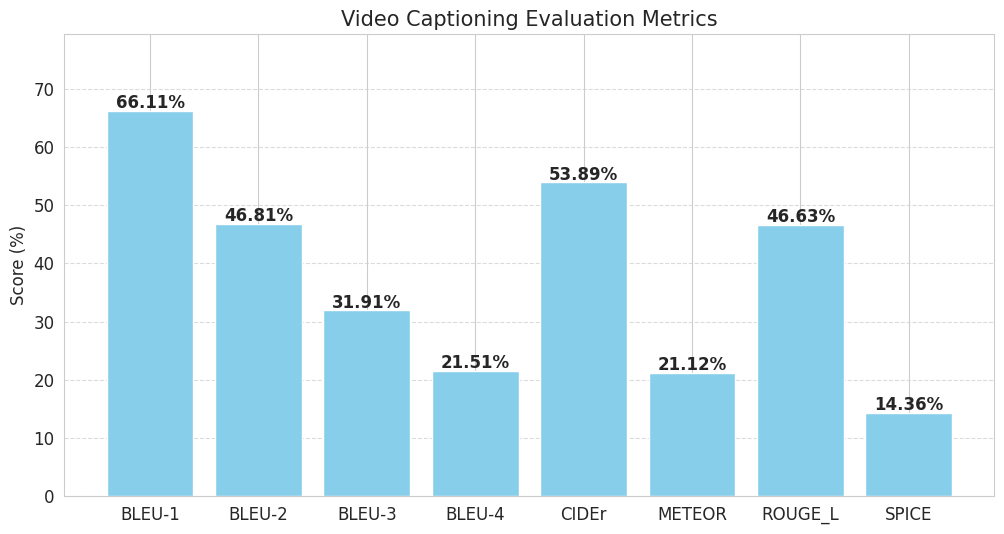


Per-Video Score Statistics:
           video_id        BLEU-4       METEOR        CIDEr      ROUGE_L
count  3.179000e+03  3.179000e+03  3179.000000  3179.000000  3179.000000
mean   3.166337e+09  1.182487e+01    22.513988    53.885121    46.626320
std    1.992677e+09  2.054409e+01    10.071280    53.242956    15.068181
min    8.164100e+04  5.386366e-11     1.275917     0.000010     8.495822
25%    1.814255e+09  6.034848e-07    15.886469    16.051269    36.526946
50%    3.217909e+09  3.918189e-03    21.047723    39.002317    45.522388
75%    4.620389e+09  2.710708e+01    27.437713    74.075312    55.816993
max    8.251170e+09  1.000000e+02   100.000000   417.586460   100.000000


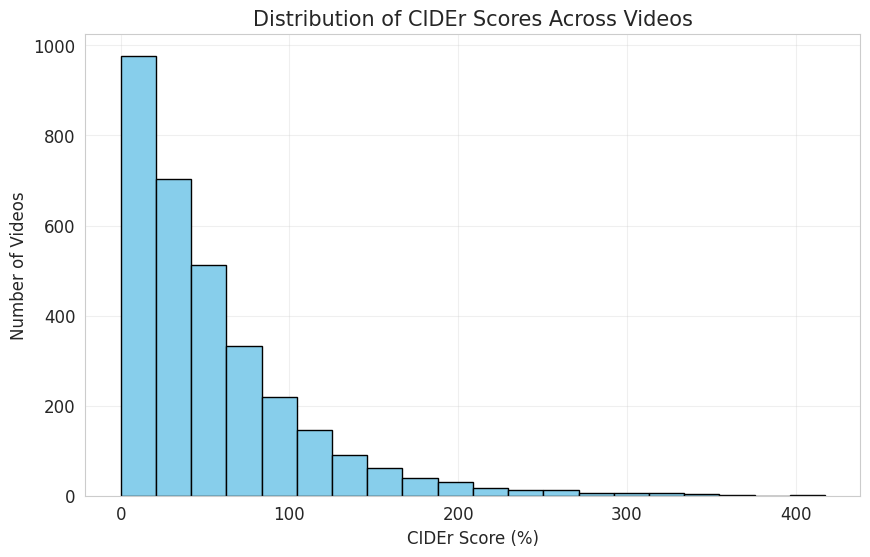


Top 10 Videos by CIDEr Score:
Video: 3406802138.0, CIDEr: 417.59%
  Prediction: Two dogs running in the dirt together.
  Reference: Two dogs kick up dirt while running down a hill .
--------------------------------------------------------------------------------
Video: 3728695560.0, CIDEr: 364.84%
  Prediction: A man holding a baby in front of a birthday cake.
  Reference: A man holding a baby and an older child admire a birthday cake with candles .
--------------------------------------------------------------------------------
Video: 1460500597.0, CIDEr: 358.11%
  Prediction: A man sitting at a table in a restaurant.
  Reference: The man in the button up shirt is sitting at a table .
--------------------------------------------------------------------------------
Video: 419518695.0, CIDEr: 350.79%
  Prediction: A man is playing with a dog in the snow.
  Reference: A man bending over holding a tennis ball and playing with his dog .
----------------------------------------------------

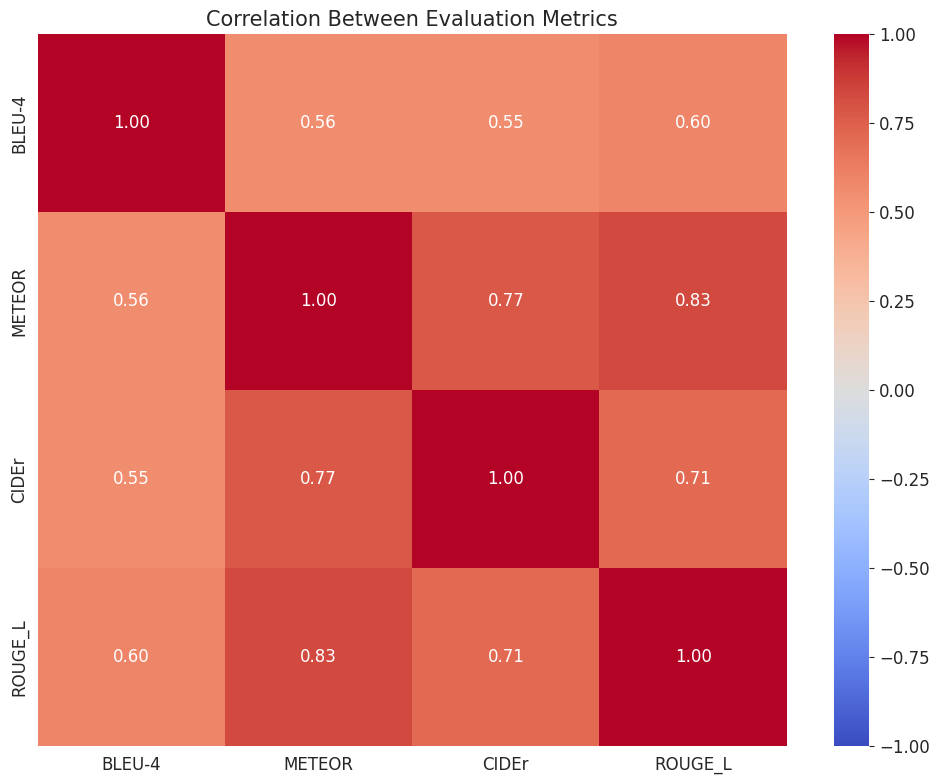

Correlation Analysis Complete


In [28]:
# Video Captioning Evaluation with pycocoevalcap
# This notebook evaluates video captioning results using the COCO evaluation metrics

# Cell 1: Import libraries
import json
import os
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

# Install pycocoevalcap if not already installed
try:
    from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.meteor.meteor import Meteor
    from pycocoevalcap.rouge.rouge import Rouge
    from pycocoevalcap.cider.cider import Cider
    from pycocoevalcap.spice.spice import Spice
except ImportError:
    print("Installing pycocoevalcap...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pycocoevalcap"])
    
    from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.meteor.meteor import Meteor
    from pycocoevalcap.rouge.rouge import Rouge
    from pycocoevalcap.cider.cider import Cider
    from pycocoevalcap.spice.spice import Spice

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Cell 2: Configure paths
# Update these paths to match your setup
OUTPUT_DIR = "/home/nasser.gawfan/CLIP_prefix_caption/experiment_final2"  # Where to save results
GROUND_TRUTH_PATH = '/home/nasser.gawfan/test_captions2.json'  # Path to MSCOCO ground truth annotations file
PREDICTIONS_PATH = "/home/nasser.gawfan/CLIP_prefix_caption/experiment_final2/filikr30k_pred.json"

# Cell 3: Load predictions and ground truth
def load_predictions(predictions_path):
    """Load predicted captions from a JSON file"""
    with open(predictions_path, 'r') as f:
        data = json.load(f)
    
    # Handle different possible formats
    if isinstance(data, list):
        # If data is a list of dictionaries with video_id and caption keys
        predictions = {item['image_id']: item['caption'] for item in data}
    elif isinstance(data, dict):
        # If data is already a dictionary
        predictions = data
    else:
        raise ValueError(f"Unexpected format in {predictions_path}")
    
    print(f"Loaded {len(predictions)} predictions")
    return predictions

def load_ground_truth(gt_path):
    """Load ground truth captions"""
    # Determine file type based on extension
    ext = os.path.splitext(gt_path)[1].lower()
    
    if ext == '.json':
        with open(gt_path, 'r') as f:
            data = json.load(f)
            
        # Handle different possible formats
        if isinstance(data, list):
            # If data is a list of dictionaries with video_id and caption(s)
            gt = defaultdict(list)
            for item in data:
                video_id = item['image_id']
                if 'enCap' in item:
                    # Multiple captions per video
                    gt[video_id].extend(item['caption'])
                elif 'caption' in item:
                    # Single caption per video
                    gt[video_id].append(item['caption'])
        elif isinstance(data, dict):
            # If data is already a dictionary with video_id -> captions
            gt = defaultdict(list)
            for video_id, captions in data.items():
                if isinstance(captions, list):
                    gt[video_id].extend(captions)
                else:
                    gt[video_id].append(captions)
    
    elif ext == '.pkl':
        with open(gt_path, 'rb') as f:
            data = pickle.load(f)
            
        # Assuming data is a list of dictionaries with video_id and caption keys
        gt = defaultdict(list)
        for item in data:
            if 'image_id' in item and 'caption' in item:
                video_id = item['image_id']
                caption = item['caption']
                gt[video_id].append(caption)
    
    else:
        raise ValueError(f"Unsupported file format: {ext}")
    
    print(f"Loaded ground truth with {len(gt)} image")
    return gt

# Load the data
print("Loading predictions...")
predictions = load_predictions(PREDICTIONS_PATH)

print("Loading ground truth...")
ground_truth = load_ground_truth(GROUND_TRUTH_PATH)

# Cell 4: Format data for COCO evaluation
def format_for_coco_eval(predictions, ground_truth):
    """Format predictions and ground truth for COCO evaluation"""
    # Find common video IDs
    common_ids = set(predictions.keys()) & set(ground_truth.keys())
    print(f"Evaluating on {len(common_ids)} videos that have both predictions and ground truth")
    
    # Store the list of common IDs for later reference
    common_ids_list = sorted(list(common_ids))
    
    # Format ground truth
    gts = {}
    for i, vid in enumerate(common_ids_list):
        gts[i] = [{'image_id': i, 'caption': caption} for caption in ground_truth[vid]]
    
    # Format predictions
    res = {}
    for i, vid in enumerate(common_ids_list):
        res[i] = [{'image_id': i, 'caption': predictions[vid]}]
    
    return gts, res, common_ids_list

gts, res, common_ids = format_for_coco_eval(predictions, ground_truth)

# Cell 5: Evaluate with pycocoevalcap
def evaluate(gts, res, metrics=None):
    """Evaluate the predictions using COCO metrics"""
    if metrics is None:
        metrics = ['BLEU', 'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE']
    
    # Tokenize
    print("Tokenizing...")
    tokenizer = PTBTokenizer()
    gts_tokenized = tokenizer.tokenize(gts)
    res_tokenized = tokenizer.tokenize(res)
    
    # Compute scores
    print("Computing metrics...")
    scores = {}
    per_video_scores = defaultdict(dict)
    
    # BLEU scores
    if 'BLEU' in metrics:
        print("Computing BLEU...")
        scorer = Bleu(n=4)
        score, scores_list = scorer.compute_score(gts_tokenized, res_tokenized)
        for i, s in enumerate(score):
            scores[f'BLEU-{i+1}'] = s
            
        # Store per-video BLEU-4 scores
        for image_id, score in enumerate(scores_list[3]):  # BLEU-4
            per_video_scores[image_id]['BLEU-4'] = score
    
    # METEOR score
    if 'METEOR' in metrics:
        print("Computing METEOR...")
        scorer = Meteor()
        score, scores_list = scorer.compute_score(gts_tokenized, res_tokenized)
        scores['METEOR'] = score
        
        # Store per-video METEOR scores
        for image_id, score in enumerate(scores_list):
            per_video_scores[image_id]['METEOR'] = score
    
    # ROUGE_L score
    if 'ROUGE_L' in metrics:
        print("Computing ROUGE-L...")
        scorer = Rouge()
        score, scores_list = scorer.compute_score(gts_tokenized, res_tokenized)
        scores['ROUGE_L'] = score
        
        # Store per-video ROUGE-L scores
        for image_id, score in enumerate(scores_list):
            per_video_scores[image_id]['ROUGE_L'] = score
    
    # CIDEr score
    if 'CIDEr' in metrics:
        print("Computing CIDEr...")
        scorer = Cider()
        score, scores_list = scorer.compute_score(gts_tokenized, res_tokenized)
        scores['CIDEr'] = score
        
        # Store per-video CIDEr scores
        for image_id, score in enumerate(scores_list):
            per_video_scores[image_id]['CIDEr'] = score
    
    # SPICE score (slower)
    if 'SPICE' in metrics:
        print("Computing SPICE (this may take a while)...")
        scorer = Spice()
        score, scores_list = scorer.compute_score(gts_tokenized, res_tokenized)
        scores['SPICE'] = score
        
        # Store per-video SPICE scores
        for image_id, score in enumerate(scores_list):
            per_video_scores[image_id]['SPICE'] = score
    
    return scores, per_video_scores

# Run evaluation
metrics_to_compute = ['BLEU', 'METEOR', 'ROUGE_L', 'CIDEr','SPICE']
overall_scores, per_video_scores = evaluate(gts, res, metrics_to_compute)

# Cell 6: Print and visualize results
# Print results
print("\nEvaluation Results:")
print("=" * 50)
for metric, score in sorted(overall_scores.items()):
    print(f"{metric:10s}: {score * 100:.4f}%")
print("=" * 50)

# Create bar chart
plt.figure(figsize=(12, 6))
metrics = sorted(list(overall_scores.keys()))
values = [overall_scores[m] * 100 for m in metrics]  # Convert to percentage

# Create bar chart
bars = plt.bar(metrics, values, color='skyblue')

# Add value labels on top of bars
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{value:.2f}%",
        ha='center',
        fontweight='bold'
    )

plt.title('Video Captioning Evaluation Metrics', fontsize=15)
plt.ylabel('Score (%)', fontsize=12)
plt.ylim(0, max(values) * 1.2)  # Leave room for text
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the chart
os.makedirs(OUTPUT_DIR, exist_ok=True)
plt.savefig(os.path.join(OUTPUT_DIR, 'evaluation_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

# Cell 7: Analyze per-video scores
# Create a DataFrame with per-video scores
video_scores_df = pd.DataFrame(
    {
        'video_id': [common_ids[idx] for idx in per_video_scores.keys()],
        **{metric: [scores.get(metric, 0) * 100 for _, scores in per_video_scores.items()] 
           for metric in ['BLEU-4', 'METEOR', 'CIDEr', 'ROUGE_L']}
    }
)

# Show summary statistics
print("\nPer-Video Score Statistics:")
print(video_scores_df.describe())

# Display histogram of CIDEr scores
plt.figure(figsize=(10, 6))
plt.hist(video_scores_df['CIDEr'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of CIDEr Scores Across Videos', fontsize=15)
plt.xlabel('CIDEr Score (%)', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'cider_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Cell 8: Find best and worst performing videos
# Sort by CIDEr score
top_videos = video_scores_df.sort_values('CIDEr', ascending=False).head(10)
bottom_videos = video_scores_df.sort_values('CIDEr', ascending=True).head(10)

print("\nTop 10 Videos by CIDEr Score:")
for i, row in top_videos.iterrows():
    video_id = row['video_id']
    print(f"Video: {video_id}, CIDEr: {row['CIDEr']:.2f}%")
    print(f"  Prediction: {predictions[video_id]}")
    print(f"  Reference: {ground_truth[video_id][0]}")
    print("-" * 80)

print("\nBottom 10 Videos by CIDEr Score:")
for i, row in bottom_videos.iterrows():
    video_id = row['video_id']
    print(f"Video: {video_id}, CIDEr: {row['CIDEr']:.2f}%")
    print(f"  Prediction: {predictions[video_id]}")
    print(f"  Reference: {ground_truth[video_id][0]}")
    print("-" * 80)

# Cell 9: Save results
# Save overall metrics
results = {
    'overall_metrics': {metric: float(f"{value * 100:.4f}") for metric, value in overall_scores.items()},
    'per_video_stats': {
        'mean': {metric: float(f"{video_scores_df[metric].mean():.4f}") for metric in video_scores_df.columns if metric != 'video_id'},
        'median': {metric: float(f"{video_scores_df[metric].median():.4f}") for metric in video_scores_df.columns if metric != 'video_id'},
        'std': {metric: float(f"{video_scores_df[metric].std():.4f}") for metric in video_scores_df.columns if metric != 'video_id'}
    }
}

# Save to JSON
with open(os.path.join(OUTPUT_DIR, 'evaluation_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

# Save per-video scores CSV for further analysis
video_scores_df.to_csv(os.path.join(OUTPUT_DIR, 'per_video_scores.csv'), index=False)

print(f"Results saved to {OUTPUT_DIR}")

# Cell 10: Correlation analysis between metrics
# Calculate correlation matrix
correlation = video_scores_df.drop('video_id', axis=1).corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Between Evaluation Metrics', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'metric_correlation.png'), dpi=300)
plt.show()

print("Correlation Analysis Complete")

In [11]:
##NOCAPS

import json
from collections import defaultdict
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

annotations_path = '/home/nasser.gawfan/Desktop/image_dataset/NoCaps/Validation_annotations/Val_annotations.json'  # Path to MSCOCO ground truth annotations file
predictions_path = "/home/nasser.gawfan/CLIP_prefix_caption/experiment_final2/no_caps_pred.json"

# Load annotations
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Extract the `images` and `annotations` sections from the annotations JSON
images = annotations.get("images", [])
annotations_data = annotations.get("annotations", [])

# Add dummy `category_id` to annotations (to avoid KeyError)
for ann in annotations_data:
    ann["category_id"] = 0  # Add a dummy category_id

categories = [{"id": 0, "name": "caption"}]  # Dummy category for compatibility

# Load predictions
with open(predictions_path, "r") as f:
    predictions = json.load(f)

# Convert `image_id` in predictions to integers to match `id` in annotations
for pred in predictions:
    pred["image_id"] = int(pred["image_id"])

for pred in predictions:
    pred["caption"] = " ".join(pred["caption"].split())

# Map each image ID to its domain
domain_mapping = {img["id"]: img["domain"] for img in images}

# Group predictions by domain
domain_predictions = defaultdict(list)
for pred in predictions:
    image_id = pred["image_id"]
    domain = domain_mapping.get(image_id, "unknown")
    domain_predictions[domain].append(pred)

# Function to evaluate predictions for a specific domain
def evaluate_predictions_by_domain(domain, images, annotations_data, predictions):
    # Filter images and annotations for the given domain
    domain_image_ids = {pred["image_id"] for pred in predictions}
    filtered_images = [img for img in images if img["id"] in domain_image_ids]
    filtered_annotations = [ann for ann in annotations_data if ann["image_id"] in domain_image_ids]

    # Prepare COCO dataset
    filtered_dataset = {
        "images": filtered_images,
        "annotations": filtered_annotations,
        "categories": categories,
    }

    # Initialize COCO objects
    coco = COCO()
    coco.dataset = filtered_dataset
    coco.createIndex()

    # Prepare predictions for COCO format
    coco_results = [
        {"image_id": pred["image_id"], "caption": pred["caption"]}
        for pred in predictions
    ]
    coco_results = coco.loadRes(coco_results)

    # Initialize evaluator and evaluate
    coco_eval = COCOEvalCap(coco, coco_results)
    coco_eval.evaluate()

    # Return evaluation results
    return coco_eval.eval


# Evaluate predictions by domain
results = {}
for domain, preds in domain_predictions.items():
    print(f"Evaluating {domain} captions...")
    domain_results = evaluate_predictions_by_domain(domain, images, annotations_data, preds)
    results[domain] = domain_results
    print(f"Results for {domain}:")
    for metric, score in domain_results.items():
        print(f"  {metric}: {score:.3f}")

for domain, scores in results.items():
    print(f"{domain.upper()}:")
    for metric, score in scores.items():
        print(f"  {metric}: {score:.3f}")



Evaluating near-domain captions...
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 359390 tokens at 1590766.95 tokens per second.
PTBTokenizer tokenized 32642 tokens at 375942.20 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 27406, 'reflen': 27074, 'guess': [27406, 24736, 22066, 19396], 'correct': [21569, 12318, 5928, 2685]}
ratio: 1.0122626874491758
Bleu_1: 0.787
Bleu_2: 0.626
Bleu_3: 0.472
Bleu_4: 0.347
computing METEOR score...
METEOR: 0.267
computing Rouge score...
ROUGE_L: 0.553
computing CIDEr score...
CIDEr: 0.834
computing SPICE score...


Parsing reference captions
Parsing test captions


SPICE evaluation took: 3.656 s
SPICE: 0.125
Results for near-domain:
  Bleu_1: 0.787
  Bleu_2: 0.626
  Bleu_3: 0.472
  Bleu_4: 0.347
  METEOR: 0.267
  ROUGE_L: 0.553
  CIDEr: 0.834
  SPICE: 0.125
Evaluating out-domain captions...
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 179060 tokens at 1149882.15 tokens per second.
PTBTokenizer tokenized 17190 tokens at 230745.62 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 14608, 'reflen': 14341, 'guess': [14608, 13195, 11782, 10369], 'correct': [10559, 5173, 2091, 745]}
ratio: 1.0186179485390825
Bleu_1: 0.723
Bleu_2: 0.532
Bleu_3: 0.369
Bleu_4: 0.245
computing METEOR score...
METEOR: 0.227
computing Rouge score...
ROUGE_L: 0.496
computing CIDEr score...
CIDEr: 0.674
computing SPICE score...


Parsing reference captions
Parsing test captions


SPICE evaluation took: 2.304 s
SPICE: 0.104
Results for out-domain:
  Bleu_1: 0.723
  Bleu_2: 0.532
  Bleu_3: 0.369
  Bleu_4: 0.245
  METEOR: 0.227
  ROUGE_L: 0.496
  CIDEr: 0.674
  SPICE: 0.104
Evaluating in-domain captions...
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 56349 tokens at 539983.00 tokens per second.
PTBTokenizer tokenized 5107 tokens at 89017.58 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 4286, 'reflen': 4234, 'guess': [4286, 3870, 3454, 3038], 'correct': [3376, 1895, 927, 416]}
ratio: 1.0122815304674038
Bleu_1: 0.788
Bleu_2: 0.621
Bleu_3: 0.470
Bleu_4: 0.345
computing METEOR score...
METEOR: 0.274
computing Rouge score...
ROUGE_L: 0.558
computing CIDEr score...
CIDEr: 0.840
computing SPICE score...


Parsing reference captions
Parsing test captions


SPICE evaluation took: 1.212 s
SPICE: 0.126
Results for in-domain:
  Bleu_1: 0.788
  Bleu_2: 0.621
  Bleu_3: 0.470
  Bleu_4: 0.345
  METEOR: 0.274
  ROUGE_L: 0.558
  CIDEr: 0.840
  SPICE: 0.126
NEAR-DOMAIN:
  Bleu_1: 0.787
  Bleu_2: 0.626
  Bleu_3: 0.472
  Bleu_4: 0.347
  METEOR: 0.267
  ROUGE_L: 0.553
  CIDEr: 0.834
  SPICE: 0.125
OUT-DOMAIN:
  Bleu_1: 0.723
  Bleu_2: 0.532
  Bleu_3: 0.369
  Bleu_4: 0.245
  METEOR: 0.227
  ROUGE_L: 0.496
  CIDEr: 0.674
  SPICE: 0.104
IN-DOMAIN:
  Bleu_1: 0.788
  Bleu_2: 0.621
  Bleu_3: 0.470
  Bleu_4: 0.345
  METEOR: 0.274
  ROUGE_L: 0.558
  CIDEr: 0.840
  SPICE: 0.126
